In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jupyter
import supabase
import dotenv
import os
from supabase import create_client, Client
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

ImportError: cannot import name 'RandomForestRegressor' from 'sklearn.linear_model' (c:\Users\gael8\Coding\uf-embs-ml\venv\lib\site-packages\sklearn\linear_model\__init__.py)

In [62]:
# init supabase client

dotenv.load_dotenv()
SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_ANON_KEY = os.getenv("SUPABASE_ANON_KEY")

supabase: Client = create_client(SUPABASE_URL, SUPABASE_ANON_KEY)

# fetch data from supabase
events_response = supabase.table("events").select("*").execute()
event_attendance_response = supabase.table("event_attendance").select("*").execute()

# convert to pandas dataframes
events_df = pd.DataFrame(events_response.data)
event_attendance_df = pd.DataFrame(event_attendance_response.data)

In [42]:
# get data

# events_df = pd.read_csv("../data/events.csv")
# event_attendance_df = pd.read_csv("../data/event_attendance.csv")

In [64]:
# simple checks

# event_attendance_df.info()
events_df.head(20)
# event_attendance_df.head()

,id,name,date,points,code,end_time,start_time,event_type,food_present,is_virtual
0,808f04f9-ad38-4040-bf2f-fecfed9b8423,Intro to Programming Workshop,2025-10-06T00:00:00+00:00,3,helloworld,2025-10-06T23:30:00+00:00,2025-10-06T21:45:00+00:00,workshop,False,False
1,620f5f25-e1ae-426b-851d-c1db8cb8f879,EMBS x NeuroTech - Virtual Academia Speaker,2025-10-02T00:00:00+00:00,3,neurooo,2025-10-02T19:15:00+00:00,2025-10-02T17:45:00+00:00,academia_speaker,False,True
2,2eab65f5-690e-4394-8a4d-0a27c74215be,Heartbeat Monitor Workshop,2025-09-26T00:00:00+00:00,3,goblin,2025-09-27T00:45:00+00:00,2025-09-26T22:15:00+00:00,workshop,False,False
3,24f885df-ef44-4ec7-8f53-600244a26205,Soldering Workshop,2025-11-20T00:00:00+00:00,3,hothot,2025-11-21T01:15:00+00:00,2025-11-20T22:45:00+00:00,workshop,False,False
4,1e19aae0-3ff3-4cc0-9976-3ac7464fc68a,Graduate School Admissions,2025-10-02T00:00:00+00:00,3,applygrad,2025-10-02T23:45:00+00:00,2025-10-02T22:15:00+00:00,academia_speaker,False,False
5,13c898b4-fcfd-4880-add8-7884695c6df9,Johnson & Johnson MedTech Virtual Industry Spe...,2025-10-16T00:00:00+00:00,2,jjtechtalk,2025-10-16T23:15:00+00:00,2025-10-16T21:45:00+00:00,industry_speaker,False,True
6,06913c7d-6e2b-4ec6-bd1b-f7cabfa0702c,Pill Dispenser Workshop,2025-11-18T00:00:00+00:00,3,skittles,2025-11-19T01:00:00+00:00,2025-11-18T22:50:00+00:00,workshop,True,False
7,05713e78-b6db-457c-aa25-7ec5ad066300,UF x UCF Vital Device Competition,2025-12-07T00:00:00+00:00,4,5XD3QABS,2025-12-08T00:00:00+00:00,2025-12-07T23:00:00+00:00,competition,False,False
8,03594c84-31e6-41eb-9182-e908ee1a5808,Pickleball Fundraiser,2025-11-15T00:00:00+00:00,4,pickle,2025-11-16T00:00:00+00:00,2025-11-15T22:00:00+00:00,fundraising,True,False
9,f0f4d88d-d2cb-428d-86b0-5ab54c90382d,Design-a-thon,2025-10-11T00:00:00+00:00,4,yaydesign,2025-10-12T00:00:00+00:00,2025-10-11T11:50:00+00:00,competition,True,False


In [60]:
# Safe merge that can be run multiple times
if "total_attendees" not in events_df.columns:
    # Get attendance counts per event
    attendance_counts = event_attendance_df.groupby("event_id").size().reset_index(name="total_attendees")
    
    # Merge with events_df (only keeping the total_attendees column)
    events_df = events_df.merge(attendance_counts[["event_id", "total_attendees"]], left_on="id", right_on="event_id", how="left")
    
    # Fill NaN with 0 and convert to int
    events_df["total_attendees"] = events_df["total_attendees"].fillna(0).astype(int)
    
    # Optional: Remove the redundant event_id column if it was added
    if "event_id" in events_df.columns:
        events_df = events_df.drop("event_id", axis=1)

# Now you can safely rerun this cell multiple times without errors
print(f"Events with attendance data: {events_df['total_attendees'].sum()}")

Events with attendance data: 168


In [59]:
# check the new updated data and remove any unneeded columns
# events_df.head(20)

events_df = events_df.drop(columns=["id", "name", "code"], axis=1, errors="ignore")

events_df.head(20)

,date,points,end_time,start_time,food_present,is_virtual,total_attendees,event_type_competition,event_type_fundraising,event_type_gbm,event_type_industry_speaker,event_type_workshop,date_local,start_time_local,end_time_local,weekday,month,day,start_hour
0,2025-10-06 00:00:00+00:00,3,2025-10-06 23:30:00+00:00,2025-10-06 21:45:00+00:00,0,0,4,False,False,False,False,True,2025-10-05 20:00:00-04:00,2025-10-06 17:45:00-04:00,2025-10-06 19:30:00-04:00,6,10,5,17
1,2025-10-02 00:00:00+00:00,3,2025-10-02 19:15:00+00:00,2025-10-02 17:45:00+00:00,0,1,0,False,False,False,False,False,2025-10-01 20:00:00-04:00,2025-10-02 13:45:00-04:00,2025-10-02 15:15:00-04:00,2,10,1,13
2,2025-09-26 00:00:00+00:00,3,2025-09-27 00:45:00+00:00,2025-09-26 22:15:00+00:00,0,0,13,False,False,False,False,True,2025-09-25 20:00:00-04:00,2025-09-26 18:15:00-04:00,2025-09-26 20:45:00-04:00,3,9,25,18
3,2025-11-20 00:00:00+00:00,3,2025-11-21 01:15:00+00:00,2025-11-20 22:45:00+00:00,0,0,2,False,False,False,False,True,2025-11-19 19:00:00-05:00,2025-11-20 17:45:00-05:00,2025-11-20 20:15:00-05:00,2,11,19,17
4,2025-10-02 00:00:00+00:00,3,2025-10-02 23:45:00+00:00,2025-10-02 22:15:00+00:00,0,0,1,False,False,False,False,False,2025-10-01 20:00:00-04:00,2025-10-02 18:15:00-04:00,2025-10-02 19:45:00-04:00,2,10,1,18
5,2025-10-16 00:00:00+00:00,2,2025-10-16 23:15:00+00:00,2025-10-16 21:45:00+00:00,0,1,3,False,False,False,True,False,2025-10-15 20:00:00-04:00,2025-10-16 17:45:00-04:00,2025-10-16 19:15:00-04:00,2,10,15,17
6,2025-11-18 00:00:00+00:00,3,2025-11-19 01:00:00+00:00,2025-11-18 22:50:00+00:00,1,0,4,False,False,False,False,True,2025-11-17 19:00:00-05:00,2025-11-18 17:50:00-05:00,2025-11-18 20:00:00-05:00,0,11,17,17
7,2025-12-07 00:00:00+00:00,4,2025-12-08 00:00:00+00:00,2025-12-07 23:00:00+00:00,0,0,12,True,False,False,False,False,2025-12-06 19:00:00-05:00,2025-12-07 18:00:00-05:00,2025-12-07 19:00:00-05:00,5,12,6,18
8,2025-11-15 00:00:00+00:00,4,2025-11-16 00:00:00+00:00,2025-11-15 22:00:00+00:00,1,0,42,False,True,False,False,False,2025-11-14 19:00:00-05:00,2025-11-15 17:00:00-05:00,2025-11-15 19:00:00-05:00,4,11,14,17
9,2025-10-11 00:00:00+00:00,4,2025-10-12 00:00:00+00:00,2025-10-11 11:50:00+00:00,1,0,16,True,False,False,False,False,2025-10-10 20:00:00-04:00,2025-10-11 07:50:00-04:00,2025-10-11 20:00:00-04:00,4,10,10,7


In [58]:
# feature engineering - date and time

# turn boolean columns into int
events_df["is_virtual"] = events_df["is_virtual"].astype(int)
events_df["food_present"] = events_df["food_present"].astype(int)

# one hot encode the event_type column
if "event_type" in events_df.columns:
    events_df = pd.get_dummies(
        events_df,
        columns=["event_type"],
        drop_first=True
    )

# turn the date and time columns into a datetime object with utc timezone
events_df["date"] = pd.to_datetime(events_df["date"], utc=True)
events_df["start_time"] = pd.to_datetime(events_df["start_time"], utc=True)
events_df["end_time"] = pd.to_datetime(events_df["end_time"], utc=True)

# convert to local timezone (est)
events_df["date_local"] = events_df["date"].dt.tz_convert("US/Eastern")
events_df["start_time_local"] = events_df["start_time"].dt.tz_convert("US/Eastern")
events_df["end_time_local"] = events_df["end_time"].dt.tz_convert("US/Eastern")

# get the useful information from datetime objects
events_df["weekday"] = events_df["date_local"].dt.weekday
events_df["month"] = events_df["date_local"].dt.month
events_df["day"] = events_df["date_local"].dt.day
events_df["start_hour"] = events_df["start_time_local"].dt.hour

events_df.head(20)

,date,points,end_time,start_time,food_present,is_virtual,total_attendees,event_type_competition,event_type_fundraising,event_type_gbm,event_type_industry_speaker,event_type_workshop,date_local,start_time_local,end_time_local,weekday,month,day,start_hour
0,2025-10-06 00:00:00+00:00,3,2025-10-06 23:30:00+00:00,2025-10-06 21:45:00+00:00,0,0,4,False,False,False,False,True,2025-10-05 20:00:00-04:00,2025-10-06 17:45:00-04:00,2025-10-06 19:30:00-04:00,6,10,5,17
1,2025-10-02 00:00:00+00:00,3,2025-10-02 19:15:00+00:00,2025-10-02 17:45:00+00:00,0,1,0,False,False,False,False,False,2025-10-01 20:00:00-04:00,2025-10-02 13:45:00-04:00,2025-10-02 15:15:00-04:00,2,10,1,13
2,2025-09-26 00:00:00+00:00,3,2025-09-27 00:45:00+00:00,2025-09-26 22:15:00+00:00,0,0,13,False,False,False,False,True,2025-09-25 20:00:00-04:00,2025-09-26 18:15:00-04:00,2025-09-26 20:45:00-04:00,3,9,25,18
3,2025-11-20 00:00:00+00:00,3,2025-11-21 01:15:00+00:00,2025-11-20 22:45:00+00:00,0,0,2,False,False,False,False,True,2025-11-19 19:00:00-05:00,2025-11-20 17:45:00-05:00,2025-11-20 20:15:00-05:00,2,11,19,17
4,2025-10-02 00:00:00+00:00,3,2025-10-02 23:45:00+00:00,2025-10-02 22:15:00+00:00,0,0,1,False,False,False,False,False,2025-10-01 20:00:00-04:00,2025-10-02 18:15:00-04:00,2025-10-02 19:45:00-04:00,2,10,1,18
5,2025-10-16 00:00:00+00:00,2,2025-10-16 23:15:00+00:00,2025-10-16 21:45:00+00:00,0,1,3,False,False,False,True,False,2025-10-15 20:00:00-04:00,2025-10-16 17:45:00-04:00,2025-10-16 19:15:00-04:00,2,10,15,17
6,2025-11-18 00:00:00+00:00,3,2025-11-19 01:00:00+00:00,2025-11-18 22:50:00+00:00,1,0,4,False,False,False,False,True,2025-11-17 19:00:00-05:00,2025-11-18 17:50:00-05:00,2025-11-18 20:00:00-05:00,0,11,17,17
7,2025-12-07 00:00:00+00:00,4,2025-12-08 00:00:00+00:00,2025-12-07 23:00:00+00:00,0,0,12,True,False,False,False,False,2025-12-06 19:00:00-05:00,2025-12-07 18:00:00-05:00,2025-12-07 19:00:00-05:00,5,12,6,18
8,2025-11-15 00:00:00+00:00,4,2025-11-16 00:00:00+00:00,2025-11-15 22:00:00+00:00,1,0,42,False,True,False,False,False,2025-11-14 19:00:00-05:00,2025-11-15 17:00:00-05:00,2025-11-15 19:00:00-05:00,4,11,14,17
9,2025-10-11 00:00:00+00:00,4,2025-10-12 00:00:00+00:00,2025-10-11 11:50:00+00:00,1,0,16,True,False,False,False,False,2025-10-10 20:00:00-04:00,2025-10-11 07:50:00-04:00,2025-10-11 20:00:00-04:00,4,10,10,7


In [47]:
# define x and y variables (y is the target variable)

X = events_df.drop(columns=["date", "start_time", "end_time", "total_attendees", "date_local", "start_time_local", "end_time_local"])
y = events_df["total_attendees"]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   points                       16 non-null     int64
 1   food_present                 16 non-null     int64
 2   is_virtual                   16 non-null     int64
 3   event_type_competition       16 non-null     bool 
 4   event_type_fundraising       16 non-null     bool 
 5   event_type_gbm               16 non-null     bool 
 6   event_type_industry_speaker  16 non-null     bool 
 7   event_type_workshop          16 non-null     bool 
 8   weekday                      16 non-null     int32
 9   month                        16 non-null     int32
 10  day                          16 non-null     int32
 11  start_hour                   16 non-null     int32
dtypes: bool(5), int32(4), int64(3)
memory usage: 848.0 bytes


In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# fit the model with training data
model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)

# print("Model feature names:", model.feature_names_in_)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


MAE: 14.631726259107893
R2: -63.41258128457842


Text(0, 0.5, 'Predicted Attendees')

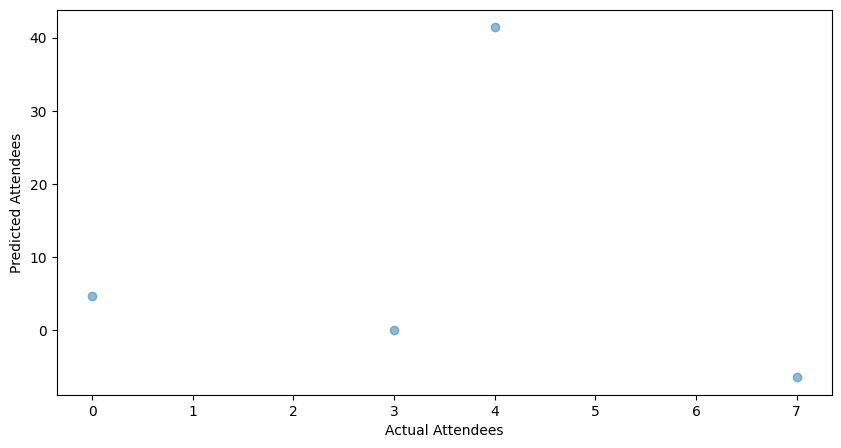

In [49]:
# evaluate the model

y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")

# plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Attendees")
plt.ylabel("Predicted Attendees")

In [65]:
# predict a future event 
future_event = {
    "points": 3,
    "food_present": 0,
    "is_virtual": 0,
    "event_type_competition": 0,
    "event_type_fundraising": 0,
    "event_type_gbm": 0,          # <-- THIS is how you say "gbm"
    "event_type_industry_speaker": 0,
    "event_type_workshop": 0,
    "weekday": 2,        # Wednesday
    "month": 0,
    "day": 15,
    "start_hour": 17,
}

# convert to dataframe
future_event_df = pd.DataFrame([future_event])

# make prediction
predicted_attendees = model.predict(future_event_df)

predicted_attendees

array([23.00597937])